In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skimage 
from skimage import io
from skimage.color import rgb2gray
import os
import skimage.feature
import skimage.filters
from skimage.util import invert
from skimage.morphology import skeletonize
from scipy.signal import correlate2d
import pandas as pd
import cv2
from pathlib import Path
from joblib import Parallel, delayed

def import_exImg():
    sample_images = {}
    if os.getcwd().split('/')[-1] != '50_categories':
        exit()
    files = os.listdir()
    for idx, direct in enumerate(files):
        if idx == 0:
            pass
        else:
            os.chdir(direct)
            file = os.listdir()[0]
            img = io.imread(file)
            sample_images[direct] = img
            os.chdir('..')
    print('Done!')
    return(sample_images)

In [2]:
def avg_red(img):
    """returns average value of red channel"""
    avg = [img[:,0].mean()]
    return np.array(avg)

def avg_blue(img):
    """returns average value of blue channel"""
    avg = [img[:,1].mean()]
    return np.array(avg)

def avg_green(img):
    """returns average value of green channel"""
    avg = [img[:,2].mean()]
    return np.array(avg)

# edges from sobel
def sobel_edges(gray_image):
    """Returns histogram of edges and average of edges"""
    edges = skimage.filters.sobel(gray_image)
    edge_hist = np.histogram(edges,bins=250, density = True)[0]
    return edge_hist

# number of blobs from difference of gaussian
def blobs_dog(gray_image):
    """returns two features: average blob size and total number of blobs detected by difference of gaussians"""
    blob = skimage.feature.blob_dog(gray_image, max_sigma=50, threshold=.1)
    blobs = blob[:,2]
    avg_blob = blobs.mean()
    num_blobs = len(blobs)
    blob_info = np.array([avg_blob, num_blobs])
    return blob_info

def blobs_log(gray_image):
    """returns two features: average blob size and total number of blobs detected by laplace of gaussians"""
    blob = skimage.feature.blob_log(gray_image, max_sigma=5, num_sigma=10, threshold=.1)
    blobs = blob[:,2]
    avg_blob = blobs.mean()
    num_blobs = len(blobs)
    blob_info = np.array([avg_blob, num_blobs])
    return blob_info

def fft_hist(gray_image):
    """returns 250 bin histogram of frequencies from fft of image"""
    fft = np.log2(abs(np.fft.rfft2(gray_image)))
    fhist = np.histogram(fft,bins=250,density = True)[0]
    return fhist

def lbp_hist(gray_image):
    """returns 250 bin histogram of local binary patterns from image"""
    print(gray_image.shape)
    lbp = skimage.feature.local_binary_pattern(gray_image,30,30)
    lhist = np.histogram(lbp,bins=250,density = True)[0]
    return lhist

In [3]:
def center_cut(image):
    """returns a 1d array of length 1200 which is 20x20 center of image of all three channels flattened"""
    middle = (image.shape[0]//2,image.shape[1]//2)
    cut = image[(middle[0]-10):(middle[0]+10),(middle[1]-10):(middle[1]+10),:].flatten()
    return cut

In [4]:
def avg_HSV(image):
    """returns the average for hue, saturation, and value from image"""
    img_out = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    results = [img_out[0].mean(),img_out[1].mean(),img_out[2].mean()]
    return np.array(results)

In [45]:
def sift10(image):
    """returns 1d array of length 1280 which represents the first 10 SIFT features of the image"""
    sift = cv2.xfeatures2d.SIFT_create()
    _, des = sift.detectAndCompute(image,None)
    if des.shape[0] <= 10:
        dif = 10 - des.shape[0]
        filler = np.zeros((dif,128))
        sift = np.concatenate((des,filler),axis=0).flatten()
    else:
        sift = des[:10,:].flatten()
    return sift

In [6]:
def color_hist(image):
    """returns 1d array of length 768 representing the color histogram for red,blue, and green channels"""
    hist = []
    if len(image.shape) == 3:
        for i in range(0,3):
            hist.append(np.histogram(image[:,:,i],bins=250, density = True)[0])
    else:
        for i in range(0,3):
            hist.append(np.histogram(image,bins=250, density = True)[0])
    hist = np.concatenate(hist)
    return hist

In [42]:
def get_features(file):
    image = io.imread(file)
    label = file.parent.name
    gray_image = rgb2gray(image)
#     print(file)
    features = [] 
    features.append(color_hist(image))
    features.append(sift10(image))
    features.append(avg_HSV(image))
    features.append(center_cut(image))
    features.append(lbp_hist(gray_image))
    features.append(fft_hist(gray_image))
    features.append(blobs_log(gray_image))
    features.append(blobs_dog(gray_image))
    features.append(sobel_edges(gray_image))
    features.append(avg_green(image))
    features.append(avg_blue(image))
    features.append(avg_red(image))
    features = np.concatenate(features)
    return (features,label)

In [43]:
from tqdm import tqdm
def feature_frame(directory):
    files = list(Path(directory).glob('*/*.jpg'))
    np.random.seed(42)
    file_list = np.random.choice(files,100)
    features = Parallel(n_jobs=1)(delayed(get_features)(file) for file in tqdm(file_list))
    print('Done!')
    feat_list, labels_list = zip(*features)
    df = pd.DataFrame.from_records(feat_list)
    df['Label'] = labels_list
    return df

In [44]:
directory = '/Users/kategroschner/Documents/Berkeley2017_2018/AY250/python-ay250-homework/hw_6/50_categories'
df = feature_frame(directory)
csv_name = directory + '/features.csv'
df.to_csv(csv_name)



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:20,  4.83it/s]

(196, 160)
(192, 256)




  2%|▏         | 2/100 [00:00<00:35,  2.74it/s]

(195, 258)




  3%|▎         | 3/100 [00:01<00:42,  2.28it/s]

(154, 410)




  4%|▍         | 4/100 [00:01<00:40,  2.34it/s]

(300, 650)




  5%|▌         | 5/100 [00:02<00:49,  1.92it/s]

(360, 240)




  6%|▌         | 6/100 [00:03<00:50,  1.88it/s]

(200, 300)




  7%|▋         | 7/100 [00:03<00:47,  1.96it/s]

(164, 404)




  8%|▊         | 8/100 [00:04<00:49,  1.87it/s]

(600, 406)




  9%|▉         | 9/100 [00:05<00:57,  1.59it/s]

 10%|█         | 10/100 [00:05<00:52,  1.73it/s]

(120, 160)
(366, 536)




 11%|█         | 11/100 [00:07<01:00,  1.47it/s]

(225, 300)




 12%|█▏        | 12/100 [00:08<01:05,  1.35it/s]

 13%|█▎        | 13/100 [00:09<01:01,  1.43it/s]

(164, 240)




 14%|█▍        | 14/100 [00:09<00:57,  1.50it/s]

(150, 198)
(480, 640)




 15%|█▌        | 15/100 [00:11<01:05,  1.30it/s]

(194, 260)




 16%|█▌        | 16/100 [00:11<01:02,  1.35it/s]

(221, 395)




 17%|█▋        | 17/100 [00:12<01:00,  1.37it/s]

(450, 397)




 18%|█▊        | 18/100 [00:13<01:02,  1.31it/s]

(128, 192)




 19%|█▉        | 19/100 [00:14<00:59,  1.36it/s]

(500, 380)




 20%|██        | 20/100 [00:18<01:15,  1.06it/s]

(630, 650)




 21%|██        | 21/100 [00:21<01:19,  1.01s/it]

(291, 450)




 22%|██▏       | 22/100 [00:22<01:18,  1.00s/it]

(478, 640)




 23%|██▎       | 23/100 [00:24<01:22,  1.08s/it]

(155, 401)




 24%|██▍       | 24/100 [00:25<01:19,  1.05s/it]

(212, 300)




 25%|██▌       | 25/100 [00:26<01:19,  1.07s/it]

(584, 880)




 26%|██▌       | 26/100 [00:30<01:28,  1.19s/it]

(500, 377)


KeyboardInterrupt: 

In [11]:
np.random.seed(42)
files = list(Path(directory).glob('*/*.jpg'))
file_list = np.random.choice(files,100)


In [38]:
file_list[12]

PosixPath('/Users/kategroschner/Documents/Berkeley2017_2018/AY250/python-ay250-homework/hw_6/50_categories/dolphin/dolphin_0037.jpg')

In [37]:
a = io.imread(file_list[12])

In [27]:
a.shape

(196, 160, 3)

In [ ]:
plt.plot(b)

In [13]:
c = lbp_hist(rgb2gray(a))

(283, 360)


In [39]:
d = sift10(a)

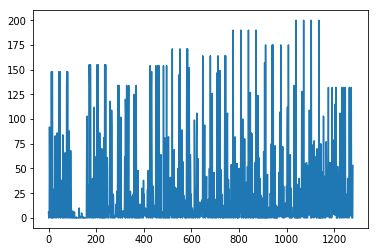

In [40]:
plt.plot(d)

In [35]:
d.shape

(1280,)

In [41]:
a.shape

(164, 240, 3)

# TEST NEW FEATURES AND MODEL

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skimage 
from skimage import io
from skimage.color import rgb2gray
import os
import skimage.feature
import skimage.filters
import skimage.color
from skimage.util import invert
from skimage.morphology import skeletonize
from scipy.signal import correlate2d
import pandas as pd
import cv2
from pathlib import Path
from joblib import Parallel, delayed
from tqdm import tqdm

def import_exImg():
    sample_images = {}
    if os.getcwd().split('/')[-1] != '50_categories':
        exit()
    files = os.listdir()
    for idx, direct in enumerate(files):
        if idx == 0:
            pass
        else:
            os.chdir(direct)
            file = os.listdir()[0]
            img = io.imread(file)
            sample_images[direct] = img
            os.chdir('..')
    print('Done!')
    return(sample_images)

def avg_red(img):
    """returns average value of red channel"""
    if len(img.shape) != 3:
        img = skimage.color.gray2rgb(img)
    avg = [img[:,:,0].mean()]
    return np.array(avg)

def avg_blue(img):
    """returns average value of blue channel"""
    if len(img.shape) != 3:
        img = skimage.color.gray2rgb(img)
    avg = [img[:,:,1].mean()]
    return np.array(avg)

def avg_green(img):
    """returns average value of green channel"""
    if len(img.shape) != 3:
        img = skimage.color.gray2rgb(img)
    avg = [img[:,:,2].mean()]
    return np.array(avg)

# edges from sobel
def sobel_edges(gray_image):
    """Returns histogram of edges"""
    edges = skimage.filters.sobel(gray_image)
    edge_hist = np.histogram(edges,bins=10, density = True)[0]
    return edge_hist

# number of blobs from difference of gaussian
def blobs_dog(gray_image):
    """returns two features: average blob size and total number of blobs detected by difference of gaussians"""
    blob = skimage.feature.blob_dog(gray_image, max_sigma=50, threshold=.1)
    blobs = blob[:,2]
    avg_blob = blobs.mean()
    num_blobs = len(blobs)
    blob_info = np.array([avg_blob, num_blobs])
    return blob_info

def blobs_log(gray_image):
    """returns two features: average blob size and total number of blobs detected by laplace of gaussians"""
    blob = skimage.feature.blob_log(gray_image, max_sigma=5, num_sigma=10, threshold=.1)
    blobs = blob[:,2]
    avg_blob = blobs.mean()
    num_blobs = len(blobs)
    blob_info = np.array([avg_blob, num_blobs])
    return blob_info

def fft_hist(gray_image):
    """returns 250 bin histogram of frequencies from fft of image"""
    fft = np.log2(abs(np.fft.rfft2(gray_image)))
    fhist = np.histogram(fft,bins=10,density = True)[0]
    return fhist

def lbp_hist(gray_image):
    """returns 250 bin histogram of local binary patterns from image"""
    lbp = skimage.feature.local_binary_pattern(gray_image,30,30)
    lhist = np.histogram(lbp,bins=10,density = True)[0]
    return lhist

def center_cut(image):
    """returns a 1d array of length 300 which is 10x10 center of image of all three channels flattened"""
    if len(image.shape) != 3:
        image = skimage.color.gray2rgb(image)
    middle = (image.shape[0]//2,image.shape[1]//2)
    cut = image[(middle[0]-5):(middle[0]+5),(middle[1]-5):(middle[1]+5),:].flatten()
    return cut

def avg_HSV(image):
    """returns the average for hue, saturation, and value from image"""
    if len(image.shape) == 3:
        img_out = skimage.color.rgb2hsv(image)
    else:
        img_out = skimage.color.rgb2hsv(skimage.color.grey2rgb(image))
    results = [img_out[:,:,0].mean(),img_out[:,:,1].mean(),img_out[:,:,2].mean()]
    return np.array(results)

def sift10(image):
    """returns 1d array of length 1280 which represents the first 10 SIFT features of the image"""
    if len(image.shape) != 3:
        image = skimage.color.gray2rgb(image)
    sift = cv2.xfeatures2d.SIFT_create()
    _, des = sift.detectAndCompute(image,None)
    if des.shape[0] <= 10:
        dif = 10 - des.shape[0]
        filler = np.zeros((dif,128))
        sift = np.concatenate((des,filler),axis=0).flatten()
    else:
        sift = des[:10,:].flatten()
    return sift

def color_hist(image):
    """returns 1d array of length 30 representing the color histogram for red,blue, and green channels"""
    hist = []
    if len(image.shape) == 3:
        for i in range(0,3):
            hist.append(np.histogram(image[:,:,i],bins=10, density = True)[0])
    else:
        for i in range(0,3):
            hist.append(np.histogram(image,bins=10, density = True)[0])
    hist = np.concatenate(hist)
    return hist

def get_features(file):
    image = io.imread(file)
    label = file.parent.name
    gray_image = rgb2gray(image)
#     print(file)
    features = [] 
    features.append(color_hist(image))
    features.append(sift10(image))
    features.append(avg_HSV(image))
    features.append(center_cut(image))
    features.append(lbp_hist(gray_image))
    features.append(fft_hist(gray_image))
    features.append(blobs_log(gray_image))
    features.append(blobs_dog(gray_image))
    features.append(sobel_edges(gray_image))
    features.append(avg_green(image))
    features.append(avg_blue(image))
    features.append(avg_red(image))
    features = np.concatenate(features)
    return (features,label)


In [20]:
def feature_frame(directory):
    files = list(Path(directory).glob('*/*.jpg'))
#     np.random.seed(42)
#     file_list = np.random.choice(files,100)
    features = Parallel(n_jobs=-1)(delayed(get_features)(file) for file in tqdm(files))
    print('Done!')
    feat_list, labels_list = zip(*features)
    df = pd.DataFrame.from_records(feat_list)
    column_names = [['color_hist']*30,['sift10']*1280,['avg_HSV']*3,['center_cut']*300,['lbp_hist']*10,\
                    ['fft_hist']*10,['blobs_log']*2,['blobs_dog']*2,['sobel_edges']*10,['avg_green'],['avg_blue'],\
                    ['avg_red']]
    column_names = sum(column_names, [])
    print(len(column_names))
    df.columns = column_names
    df['Label'] = labels_list
    return df

In [22]:
directory = '/Users/kategroschner/Documents/Berkeley2017_2018/AY250/python-ay250-homework/hw_6/50_categories'
df_full = feature_frame(directory)
csv_name = directory + '/all_features2.csv'
df_full.to_csv(csv_name)
df_full.to_pickle(directory+'/all_features2.py')

 20%|██        | 853/4244 [07:50<31:09,  1.81it/s]/Users/kategroschner/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:79: RuntimeWarning: Mean of empty slice.
/Users/kategroschner/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 66%|██████▌   | 2808/4244 [1:34:12<48:10,  2.01s/it]  /Users/kategroschner/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:79: RuntimeWarning: Mean of empty slice.
/Users/kategroschner/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 67%|██████▋   | 2838/4244 [1:34:22<46:45,  2.00s/it]/Users/kategroschner/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:79: RuntimeWarning: Mean of empty slice.
/Users/kategroschner/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value 

Done!
1650


In [40]:
df_full.replace([np.inf, -np.inf], np.nan)
df_full.fillna(value = 0.1)

,color_hist,color_hist,color_hist,color_hist,color_hist,color_hist,color_hist,color_hist,color_hist,color_hist,...,sobel_edges,sobel_edges,sobel_edges,sobel_edges,sobel_edges,sobel_edges,avg_green,avg_blue,avg_red,Label
0,0.000855,0.000637,0.001029,0.001321,0.002427,0.004037,0.002598,0.008609,0.012074,0.005627,...,0.203285,0.071173,0.024785,0.017054,0.008641,0.000910,149.151581,176.750337,183.355727,airplanes
1,0.000394,0.001753,0.000724,0.000598,0.000583,0.000575,0.000807,0.007638,0.007390,0.020025,...,0.183180,0.131319,0.098013,0.066849,0.058998,0.013322,164.805242,189.280101,210.739822,airplanes
2,0.000486,0.001072,0.001172,0.003314,0.007113,0.002009,0.004760,0.006349,0.003417,0.009523,...,0.453821,0.242851,0.088713,0.050733,0.012198,0.005545,111.753798,147.788681,170.123787,airplanes
3,0.000808,0.001684,0.002249,0.003762,0.007673,0.007156,0.003257,0.002850,0.002709,0.007534,...,0.407122,0.261810,0.106562,0.029062,0.018133,0.002732,77.917303,132.648316,152.159752,airplanes
4,0.002137,0.003034,0.002360,0.002608,0.004782,0.006413,0.006245,0.002114,0.000827,0.008696,...,0.337039,0.236395,0.097367,0.045173,0.023405,0.009830,86.252963,150.504790,147.397886,airplanes
5,0.000575,0.002155,0.002192,0.003857,0.004324,0.001168,0.006959,0.005593,0.000880,0.011514,...,0.194119,0.128893,0.096150,0.062368,0.030144,0.011434,144.797615,166.582420,167.209223,airplanes
6,0.000482,0.001453,0.001879,0.001353,0.001497,0.001518,0.004947,0.009545,0.007428,0.009424,...,0.320853,0.200270,0.103744,0.079086,0.036085,0.008420,176.820142,189.446706,185.957680,airplanes
7,0.000840,0.003500,0.006796,0.008626,0.007196,0.003625,0.001602,0.000767,0.000876,0.005388,...,0.390685,0.261575,0.183046,0.112343,0.055054,0.012296,96.766307,111.639470,117.929114,airplanes
8,0.000264,0.000928,0.001615,0.003436,0.005569,0.004410,0.001922,0.001145,0.003344,0.016582,...,0.269746,0.150618,0.084952,0.027341,0.006347,0.001221,147.024243,168.905691,180.656595,airplanes
9,0.003711,0.003048,0.001989,0.001502,0.005509,0.004708,0.000990,0.000237,0.000302,0.017219,...,0.154661,0.117947,0.086437,0.043652,0.029487,0.018791,127.470922,145.088216,161.148872,airplanes


In [48]:
if any(df_full2.isna()):
    print('True')

True


In [95]:
df_full2 = df_full.dropna(axis = 0)

In [65]:
from sklearn.utils import shuffle
df_full2 = shuffle(df_full2, random_state=0)

In [96]:
train_set = pd.DataFrame(columns=df_full2.columns.values)
test_set = pd.DataFrame(columns=df_full2.columns.values)
names_list = df_full2['Label'].drop_duplicates()
for name in names_list:
    temp = df_full2[df_full2.values == name]
    train_set=train_set.append(temp.iloc[:50,:])
    test_set=test_set.append(temp.iloc[50:,:])

train_set = shuffle(train_set, random_state=0)
test_set = shuffle(test_set, random_state=0)
X_train = train_set.iloc[:,:-1]
Y_train = train_set.iloc[:,-1]
X_test = test_set.iloc[:,:-1]
Y_test = test_set.iloc[:,-1]


In [104]:
Y_test.drop_duplicates().count()

50

In [86]:
train_set.append(df_full2[df_full2.values == names_list.iloc[0]].iloc[:50,:])

,color_hist,color_hist,color_hist,color_hist,color_hist,color_hist,color_hist,color_hist,color_hist,color_hist,...,sobel_edges,sobel_edges,sobel_edges,sobel_edges,sobel_edges,sobel_edges,avg_green,avg_blue,avg_red,Label
3564,0.003987,0.008421,0.003221,0.002126,0.002124,0.002308,0.002382,0.003089,0.003663,0.007895,...,0.634840,0.397789,0.228026,0.111136,0.022954,0.001030,40.749404,64.659972,128.970828,snail
3599,0.001414,0.003028,0.003336,0.002588,0.002482,0.001880,0.001142,0.000695,0.000459,0.022191,...,0.207888,0.145760,0.103705,0.084111,0.047312,0.028196,175.086219,178.992350,183.190978,snail
3625,0.001534,0.002493,0.003445,0.003540,0.005202,0.006554,0.005574,0.002737,0.002361,0.005775,...,0.171768,0.088352,0.047295,0.039499,0.016111,0.006237,108.507419,128.452166,141.138141,snail
3626,0.002481,0.002940,0.004476,0.004040,0.003738,0.002810,0.003014,0.004477,0.007032,0.004208,...,0.137092,0.077019,0.044551,0.020925,0.006631,0.000835,128.425301,129.814458,140.845012,snail
3594,0.000883,0.000411,0.000989,0.001838,0.004974,0.004340,0.003843,0.005214,0.007923,0.008800,...,0.152059,0.124844,0.094605,0.012744,0.002592,0.156703,104.459213,126.597236,177.020336,snail
3613,0.008115,0.000775,0.002871,0.003230,0.004763,0.005488,0.006030,0.004416,0.002366,0.001162,...,0.341439,0.198317,0.151256,0.090831,0.052291,0.039121,90.912669,114.656582,114.159573,snail
3612,0.002118,0.002428,0.003155,0.003148,0.004594,0.003067,0.004407,0.006614,0.008487,0.001197,...,0.122813,0.093564,0.058983,0.027956,0.013574,0.001939,123.469640,145.163960,144.919680,snail
3565,0.001750,0.002974,0.008369,0.006657,0.005293,0.003938,0.003505,0.002281,0.001550,0.002898,...,0.024193,0.020114,0.017035,0.018355,0.021234,0.006278,93.435875,106.833598,114.911155,snail
3591,0.025507,0.004190,0.001955,0.001806,0.002342,0.001687,0.000861,0.000389,0.000244,0.000233,...,0.165083,0.082541,0.039633,0.015722,0.008844,0.000655,31.060532,84.803495,35.603843,snail
3635,0.002115,0.016072,0.006453,0.002118,0.001947,0.002071,0.002397,0.002123,0.002433,0.001489,...,0.226812,0.126097,0.064425,0.025281,0.011111,0.003262,64.861861,78.909437,87.570681,snail


In [88]:
train_set.head()

,color_hist,color_hist,color_hist,color_hist,color_hist,color_hist,color_hist,color_hist,color_hist,color_hist,...,sobel_edges,sobel_edges,sobel_edges,sobel_edges,sobel_edges,sobel_edges,avg_green,avg_blue,avg_red,Label


In [62]:
Y_test.drop_duplicates().count()

50

In [51]:
Y_train.head()


3564        snail
410     airplanes
3878         swan
1488         frog
840         comet
Name: Label, dtype: object

In [105]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=50)
classifier.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [8]:
files = list(Path(directory).glob('*/*.jpg'))
np.random.seed(42)
file_list = np.random.choice(files,100)

In [9]:
file_list[27]

PosixPath('/Users/kategroschner/Documents/Berkeley2017_2018/AY250/python-ay250-homework/hw_6/50_categories/duck/duck_0049.jpg')

In [110]:
pred_rf = classifier.predict(X_test) 
match = 0
for idx, ele in enumerate(pred_rf[0:1000]):
    if ele == Y_test.iloc[idx]:
        match += 1
print("True Class / Predicted class")
print(match/1000)

True Class / Predicted class
0.249


In [107]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# explore 3 different forest sizes and 3 choices of mtry
parameters = {'n_estimators':[10,20,30,50,70,100],  'max_features':[3,8,10,'auto'], 
             'criterion': ['gini','entropy']}
rf_tune = model_selection.GridSearchCV(RandomForestClassifier(), parameters, 
                                   n_jobs = -1, cv = 5,verbose=1)
rf_opt = rf_tune.fit(X_train, Y_train)

print("Best zero-one score: " + str(rf_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(rf_opt.best_estimator_))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.6min finished


Best zero-one score: 0.1644

Optimal Model:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [21]:
df.to_pickle(directory+'/features2.py')

In [108]:
df_full2.to_pickle(directory+'df_full2.py')
train_set.to_pickle(directory+'train_set.py')
test_set.to_pickle(directory+'test_set.py')

In [112]:
import seaborn as sns

%matplotlib inline
feature_importances = rf_opt.best_estimator_.feature_importances_
# feature_importances = feature_importances.reshape(8,8)
print(feature_importances.shape)
sns.heatmap(feature_importances, cmap=plt.cm.viridis)

(1650,)


IndexError: Inconsistent shape between the condition and the input (got (1650, 1) and (1650,))

In [137]:
feat_importance = np.vstack((train_set.columns.values[:1650],classifier.feature_importances_))

In [139]:
feat_importance

array([['color_hist', 'color_hist', 'color_hist', ..., 'avg_green',
        'avg_blue', 'avg_red'],
       [0.0023104412377752863, 0.0017108829395307262,
        0.0010827208074487597, ..., 0.0021097373433866754,
        0.0023466485420529913, 0.001859757109395895]], dtype=object)

In [150]:
previous = feat_importance[0,0]
classes = [previous]
counts = []
temp_count = 0
for idx, classify in enumerate(feat_importance[0,:]):
    if classify == previous:
        temp_count += feat_importance[1,idx]
        previous = classify
    else:
        counts.append(temp_count)
        classes.append(classify)
        temp_count = 0
        temp_count += feat_importance[1,idx]
        previous = classify
        print(previous)
        
counts.append(temp_count)

sift10
avg_HSV
center_cut
lbp_hist
fft_hist
blobs_log
blobs_dog
sobel_edges
avg_green
avg_blue
avg_red


In [159]:
print(classes)

['color_hist', 'sift10', 'avg_HSV', 'center_cut', 'lbp_hist', 'fft_hist', 'blobs_log', 'blobs_dog', 'sobel_edges', 'avg_green', 'avg_blue', 'avg_red']


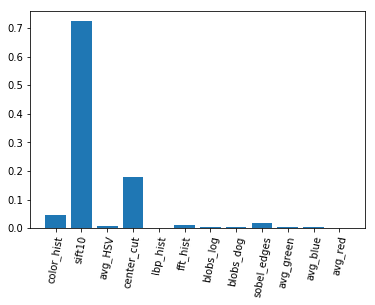

In [170]:
fig, ax = plt.subplots()
plt.bar(np.arange(1,13),counts,tick_label = classes)
# ax.set_xticklabels(classes)
for tick in ax.get_xticklabels():
    tick.set_rotation(80)

In [130]:
train_set.columns.values[:1650].shape

(1650,)

In [ ]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=classifier, n_features_to_select=1, step=1)
rfe.fit(X_train, Y_train)